In [1]:
# https://keras.io/
!pip install -q keras
import keras

Using TensorFlow backend.


### Importing files from local Storage from the zip file

Select the two h5 files from the zip -AJITH_BATCH_A_maxmin_24.h5 & AJITH_BATCH_A_maxmin_32.h5

In [0]:
from google.colab import files

uploaded = files.upload()

Saving AJITH_BATCH_A_maxmin_24.h5 to AJITH_BATCH_A_maxmin_24.h5
Saving AJITH_BATCH_A_maxmin_32.h5 to AJITH_BATCH_A_maxmin_32.h5


## INTRODUCTION

![deep](https://media.giphy.com/media/Wl41W6wJaVE8U/giphy.gif)

## MAXMIN Convolutional Neural Network 

>This is a better alternative to classical CNN. Usually Classical CNN successively uses linear filters, non linear activation functions(ReLU) and pooling functions. For example,  when a ReLU activation function is used , all the negative information is removed. This leads to the removal of information which may be good for the whole architecture. PReLU came after ReLU to tackle this problem. It multiplies negative values with a learnable coefficient instead of setting them to zero. This helps to filter less information without removing the non linear property of the ReLU.

>You can find the paper about Maxmin Convolution [here](https://arxiv.org/pdf/1610.07882.pdf)

>Other advanced algorithms for image classification were based on bag of words models. They create a visual list from the local image descriptors. When we run an image through the classifier, the local detection values of the words are pooled together to represent the final image feature, which is given as input for a SVM classifier. The CNN architecture is a sequence of convolutional blocks followed by some fully connected layers. In bag of words method, there is a loss of spatial information.

>In the case of MaxMin Pooling, the convolutional architecture is changed and ReLU is used. This will keep the negative information that  is usually lohst after the ReLU. This method aims at transmitting
directly the negative detections from a filter in order to prevent  the  network  to  learn  the  opposite  filter. 

>For filter h the negative filter $ h^− =−h $ verifies for all input $ x$,

> &nbsp;    &nbsp;  $x∗h^− = x ∗ (−h) = −(x∗h)$.



>If the pattern filtered by $h^−$ is strongly detected on $x$ then $x ∗ h^− $will be high and positive while $x∗h$ will be symmetrically low and negative.  So the information lost is very less. 

>![Figure](https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/59b71e19819c1c6aee98020b34bf92e605f33819/2-Figure1-1.png)

>Steps :
 1.  Duplicate the convolutional maps and multiply them with -1 which will result in negative of the maps.
 2. Concatenate the original maps with the negative maps which will increase the depth of the convolutional layers output.
 3. Apply ReLU  to the concatenated output .
 4. Add a pooling process to the output.
 
 >![Figure](http://webia.lip6.fr/~blot/docs/publi/maxmin/ilustration.png)
 
>We notice that the blocks output is not changing after the pooling is applied to the ReLU.



>&nbsp;&nbsp;$max(ReLU(X))$, $ max(ReLU(−X))$ =
$ReLU(max(X))$, $ ReLU(−min(X))$ where X is a vector.


>So this method can be interpreted as simply adding an additional information at pooling function with a bi-dimensional output when applied before the ReLU.

>MaxMin strategy aims at preserving and propagating significant negative detection values through the net. This difference with standard CNN enables us to preserve and transfer more information through the network.

## Code Implementation

### Let's Look Into It

![Figure](https://media.giphy.com/media/Gpf8A8aX2uWAg/giphy.gif)

The model uses Maxmin Convolution along with transfer learning and Winograd to improve the accuracy. 

A neural network is trained on a data. This network gains knowledge from this data, which is compiled as “weights” of the network. These weights can be extracted and then transferred to any other neural network. Instead of training the other neural network from scratch, we “transfer” the learned features.


In this case, we are using reduced size of the images i.e , 24x24 for limited epochs and then we will be using original images i.e , 32x32 for more epochs The 24x24 model will act as the pre-trained model for the original cifar 10 dataset. This is actually used for data augmentation along with the  augmentation provided in the keras. So as to improve the accuracy.

Also , winograd is used to reduce the number of parameters.

## MaxMin Convolution Code

>This is the piece of code that will enable us to use the MaxMin Convolution in the network. 

>The necessary libraries are imported such as convolution ,activations etc.The parameters such as the number of filters, kernel size, strides, padding, e.t.c are initialized here. 

>The input shape is initialized for the convolution.

>```python
output = K.concatenate([output, -output], axis=3)```

>This layer  simply takes the output of Convolution2D (which is a 4D tensor), and concatenates it with its own negative copy. Concatenation occurs along the axis of channels.
 
 
>The function **compute_output_shape** executes so that the output shape is doubled along the axis representing channels due to concatenation of two identical sized Convolution layers.

>The output shape is returned as a tuple.


In [3]:
from keras import backend as K
from keras.layers.convolutional import _Conv
from keras import activations
from keras.engine import InputSpec
from keras.layers.convolutional import Conv2D

class MaxMinConvolution2D(Conv2D):

    def __init__(self, filters,
                 kernel_size,
                 strides=(1, 1),
                 padding='valid',
                 data_format=None,
                 dilation_rate=(1, 1),
                 activation=None,
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        super(MaxMinConvolution2D, self).__init__(

            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            padding=padding,
            data_format=data_format,
            dilation_rate=dilation_rate,
            activation=activation,
            use_bias=use_bias,
            kernel_initializer=kernel_initializer,
            bias_initializer=bias_initializer,
            kernel_regularizer=kernel_regularizer,
            bias_regularizer=bias_regularizer,
            activity_regularizer=activity_regularizer,
            kernel_constraint=kernel_constraint,
            bias_constraint=bias_constraint,
            **kwargs)

    def build(self, input_shape):
        super(MaxMinConvolution2D, self).build(input_shape)

    def call(self, x):

        output = super(MaxMinConvolution2D, self).call(x)
        output = K.concatenate([output, -output], axis=3)
        return output

    def compute_output_shape(self, input_shape):
        """The output shape is doubled along the axis representing channels due
           to concatenation of two identical sized Convolution layers.
        """
        output_shape = super(MaxMinConvolution2D, self).compute_output_shape(input_shape)

        output_shape = list(output_shape)

        output_shape[3] *= 2

        return tuple(output_shape)

# MaxMin CNN

## Importing libraries

The necessary libraries and datasets are imported. 

In [4]:
import keras
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Concatenate
from keras.optimizers import Adam

**Sequential**  - It is created by passing a list of layer instances to the constructor.

**Activation**  - To convert a input signal of a node in a A-NN to an output signal.

**MaxPooling** -  To down-sample an input representation (image, hidden-layer output matrix, etc.), reducing its dimensionality and allowing for assumptions to be made about features.

**BatchNormalization** - Reduces the amount by what the hidden unit values shift around (covariance shift).

**Adam** - An extension to stochastic gradient descent. A learning rate is maintained for each network weight (parameter) and separately adapted as learning unfolds.

In [5]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf
from keras import backend as k

# Don't pre-allocate memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))


## Hyperparameters

**Batch size**  is set to 32 as a increase in size will give resource exhaust error in google error.

**Number classes** is the number of classes in the CIFAR 10 dataset.

**Epochs** is the one pass of the full training set.

**Learning Rate** is a hyper-parameter that controls how much we are adjusting the weights of our network with respect the loss gradient.

**Compression** is a hyper parameter to regulate the number of filters.

**Dropout Rate** is a technique where randomly selected neurons are ignored during training.



In [6]:
# Hyperparameters
batch_size = 32
num_classes = 10
epochs = 50
l = 12
num_filter = 64
compression = 1.0
dropout_rate = 0.2


## Downloading Dataset

### Training Data:
We use the publicly available **CIFAR-10** dataset to train the networks. Keras provides utilities to download and cache the dataset so nothing needs to be additionally downloaded beforehand.

**Number of training examples**: 50000

**Number of validation examples**: 10000

**Number of classes**: 10

**Description**:

* 10 mutually exclusive classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck
* (32 x 32) colored images with 3 channels (RGB). More information here.

In [7]:
# Load CIFAR10 Data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]

# convert to one hot encoing 
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


170500096/170498071 [==============================] - 32s 0us/step


### Displaying few images from the dataset

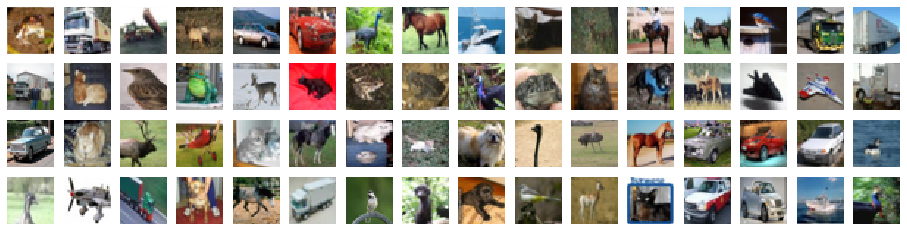

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

# Changing default figure size for properly accomodating images
from pylab import rcParams
rcParams['figure.figsize'] = (16, 4)

# Show first 64 training images
for i in range(64):
    # Choosing a subplot to plot an image
    plt.subplot(4, 16, i + 1)

    # We don't need 0, 5, 10, 15... ticks on axes for images, removing them
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(x_train[i])
plt.show()

### Changing the training images from 32x32  to 24x24 size

In [9]:
import numpy as np
import skimage.transform as st

img =x_train[0]

x_train_24 = []
x_test_24 = []

for i in range(0, x_train.shape[0]):
  x_train_24.append(st.resize(x_train[i],(24,24)))
for i in range(0, x_test.shape[0]):
  x_test_24.append(st.resize(x_test[i],(24,24)))
  
x_train_24 = np.array(x_train_24)
x_test_24 = np.array(x_test_24)

img_height, img_width, channel = x_train_24.shape[1],x_train_24.shape[2],x_train_24.shape[3]

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


### Blocks used for Neural Network


* Dense Block Function


* Transition block, with composite layers of BatchNorm - Activation - Bottleneck Conv2D1x1-Dropout-2x2 Pooling between two dense blocks

* Final Dense layer following global pooling of 2x2




In [12]:
# Dense Block
def add_denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l):
        BatchNorm = BatchNormalization()(temp)
        relu = Activation('relu')(BatchNorm)
        Conv2D_3x1 = MaxMinConvolution2D(int(num_filter*compression), (3,1), use_bias=False ,padding='same')(relu)
        Conv2D_3x3 = MaxMinConvolution2D(int(num_filter*compression), (1,3), use_bias=False ,padding='same')(Conv2D_3x1)

        if dropout_rate>0:
          Conv2D_3x3 = Dropout(dropout_rate)(Conv2D_3x3)
        concat = Concatenate(axis=-1)([temp,Conv2D_3x3])
        
        temp = concat
        
    return temp


def add_transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = MaxMinConvolution2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
      Conv2D_BottleNeck = Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    
    return avg

def output_layer(input):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    AvgPooling = AveragePooling2D(pool_size=(2,2))(relu)
    flat = Flatten()(AvgPooling)
    output = Dense(num_classes, activation='softmax')(flat)
    
    return output


### Densenet Architecture 

![Figure](https://cambridgespark.com/content/tutorials/convolutional-neural-networks-with-keras/figures/cnn.png)
1. Input layer
2. MaxMin convolution with winograd (3x1, 1x3) 
3. Four Dense Block with layer depth alternatively with transition block
4. Last block is the output layer.


In [13]:
input = Input(shape=(img_height, img_width, channel,))

First_Conv2D_3x1 = MaxMinConvolution2D(num_filter, (3,1), use_bias=False ,padding='same')(input)
First_Conv2D = MaxMinConvolution2D(num_filter, (1,3), use_bias=False ,padding='same')(First_Conv2D_3x1)

First_Block = add_denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = add_transition(First_Block, num_filter, dropout_rate)

Second_Block = add_denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = add_transition(Second_Block, num_filter, dropout_rate)

Third_Block = add_denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = add_transition(Third_Block, num_filter, dropout_rate)

Last_Block = add_denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)



### Model Summary 

In [14]:
model = Model(inputs=[input], outputs=[output])
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 24, 24, 3)    0                                            
__________________________________________________________________________________________________
max_min_convolution2d_5 (MaxMin (None, 24, 24, 128)  576         input_2[0][0]                    
__________________________________________________________________________________________________
max_min_convolution2d_6 (MaxMin (None, 24, 24, 128)  24576       max_min_convolution2d_5[0][0]    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 24, 24, 128)  512         max_min_convolution2d_6[0][0]    
__________________________________________________________________________________________________
activation

activation_48 (Activation)      (None, 3, 3, 1024)   0           batch_normalization_48[0][0]     
__________________________________________________________________________________________________
max_min_convolution2d_96 (MaxMi (None, 3, 3, 128)    196608      activation_48[0][0]              
__________________________________________________________________________________________________
max_min_convolution2d_97 (MaxMi (None, 3, 3, 128)    24576       max_min_convolution2d_96[0][0]   
__________________________________________________________________________________________________
dropout_47 (Dropout)            (None, 3, 3, 128)    0           max_min_convolution2d_97[0][0]   
__________________________________________________________________________________________________
concatenate_44 (Concatenate)    (None, 3, 3, 1152)   0           concatenate_43[0][0]             
                                                                 dropout_47[0][0]                 
__________

### Model Compilation

Before training a model, you need to configure the learning process, which is done via the compile method. It receives three arguments:

1. optimizer
2. loss function ( objective is to reduce it)
3. metrics 

In [15]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])


###  CallBacks

![Figure](https://media.giphy.com/media/35Kf7OnQCkPj2Ojtf6/giphy.gif)

1. **Model CheckPoint** - Save the model after every epoch  with the best validation accuracy.
2. **Reducing Learning Rate**  - Reduce learning rate when a metric has stopped improving.


In [16]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
# Model CheckPoint
filepath="weights.best.hdf5"
checkpoint= ModelCheckpoint(filepath,monitor= 'val_acc', verbose=1, save_best_only= True, mode='max')

#Reducing Learning Rate 
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1, 
                              patience=4, 
                              mode='auto', 
                              min_delta=0.0001, 
                              cooldown=0, 
                              min_lr=0)

callbacks = [checkpoint,reduce_lr]

### Data Augmentation 

![Figure](https://i.stack.imgur.com/UKwFg.jpg)

Generate batches of tensor image data with real-time data augmentation. The data will be looped over (in batches).

Different arguments implemented to create different types of images by changing the width , height, zoom, rotation and also flipping the image horizontally or vertically.

In [17]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(featurewise_center=True,
                          featurewise_std_normalization=True,
                          rotation_range=20, 
                          width_shift_range=0.2, 
                          height_shift_range=0.2, 
                          zoom_range=0.15,
                          horizontal_flip=True)
datagen.fit(x_train_24)

### Model Training 

Trains the model for a given number of epochs (iterations on a dataset).

The training data is 24x24 of size images.

Epoch is set to 20 to pre-train the model.

Validation data is the test data 

In [29]:
#First 20 epoch training
model.fit(x_train_24, y_train,
                    batch_size=batch_size,
                    epochs=20,
                    verbose=1,
                    callbacks=callbacks,
                    validation_data=(x_test_24, y_test))




Train on 50000 samples, validate on 10000 samples
Epoch 1/20
 1984/50000 [>.............................] - ETA: 27:02 - loss: 2.2811 - acc: 0.2127

KeyboardInterrupt: ignored

### Removing Layers
The last two layers of the neural network is removed i.e the flatten and fully connected layers.

The summary of the model is displayed

The weights are saved inorder to keep it as the pre-trained model weights.

The weights are downloaded as a h5 file to the local storage.

In [30]:
#Removing last two layers(Flatten and Fully Connected)
model.layers.pop()
model.layers.pop()
model.summary()
model.save_weights("AJITH_BATCH_A_maxmin_24.h5")
print("Saved model to disk")

#Saving the model to local storage
from google.colab import files

files.download('Transfer_mine_24_p.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 24, 24, 3)    0                                            
__________________________________________________________________________________________________
max_min_convolution2d_203 (MaxM (None, 24, 24, 128)  576         input_3[0][0]                    
__________________________________________________________________________________________________
max_min_convolution2d_204 (MaxM (None, 24, 24, 128)  24576       max_min_convolution2d_203[0][0]  
__________________________________________________________________________________________________
batch_normalization_105 (BatchN (None, 24, 24, 128)  512         max_min_convolution2d_204[0][0]  
__________________________________________________________________________________________________
activation

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Saved model to disk


In [0]:
model.load_weights('AJITH_BATCH_A_maxmin_24.h5')

### DenseNet Architecture

The  architecture is same as that of 24x24 model. It should be kept same  otherwise the weights cannot be loaded to the model

In a neural network, neurons are organized in layers. Different layers may perform different kinds of transformations on their inputs. Signals travel from the first layer (input), to the last one (output), possibly after traversing the layers multiple times. As the last hidden layer, the “bottleneck” has enough summarized information to provide the next layer which does the actual classification task.

At last three layers are added inorder to derive good results.
 
 1. Batch Normalisation
 2. Activation layer
 3. Average Pooling
 

In [31]:
input_32 = Input(shape=(32,32,3,))

First_Conv2D_3x1 = MaxMinConvolution2D(num_filter, (3,1), use_bias=False ,padding='same')(input_32)
First_Conv2D = MaxMinConvolution2D(num_filter, (1,3), use_bias=False ,padding='same')(First_Conv2D_3x1)


First_Block = add_denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = add_transition(First_Block, num_filter, dropout_rate)

Second_Block = add_denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = add_transition(Second_Block, num_filter, dropout_rate)

Third_Block = add_denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = add_transition(Third_Block, num_filter, dropout_rate)

Last_Block = add_denseblock(Third_Transition,  num_filter, dropout_rate)
BatchNorm = BatchNormalization()(Last_Block)
relu = Activation('relu')(BatchNorm)
AvgPooling = AveragePooling2D(pool_size=(2,2))(relu)


model_32 = Model(inputs=[input_32], outputs=[AvgPooling])
model_32.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
max_min_convolution2d_304 (MaxM (None, 32, 32, 128)  576         input_4[0][0]                    
__________________________________________________________________________________________________
max_min_convolution2d_305 (MaxM (None, 32, 32, 128)  24576       max_min_convolution2d_304[0][0]  
__________________________________________________________________________________________________
batch_normalization_157 (BatchN (None, 32, 32, 128)  512         max_min_convolution2d_305[0][0]  
__________________________________________________________________________________________________
activation

### Model Compilation

This is created for the pre-trained model

Before training a model, you need to configure the learning process, which is done via the compile method. It receives three arguments:

1. optimizer: Adam
2. loss function ( objective is to reduce it)--categorical cross entropy
3. metrics : accuracy

In [32]:
model_32.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])


### Loading Weights 

The weights from the pretrained model of 24x24 image sizes are loaded into the model for training 32x32 images 


In [33]:
#Load the weights  from 24x24 model
model_32.load_weights("AJITH_BATCH_A_maxmin_24.h5")


### Addition of two layers for a connected model
 
 The output of the model is flattened and is feeded into the softmax layer to give the predictions.
 

In [34]:
#Adding the last two layers to create a connected model

flat = Flatten()(model_32.output)
output = Dense(num_classes, activation='softmax')(flat)

model = Model(inputs=[model_32.input],outputs=[output])

### Model Compilation 32x32

Before training a model, you need to configure the learning process, which is done via the compile method. It receives three arguments:

1. optimizer: Adam
2. loss function ( objective is to reduce it)--categorical cross entropy
3. metrics : accuracy

In [35]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

### Data Augmentation

In [36]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(featurewise_center=True,
                          featurewise_std_normalization=True,
                          rotation_range=20, 
                          width_shift_range=0.2, 
                          #shear_range=0.2,
                          height_shift_range=0.2, 
                          zoom_range=0.15,
                          horizontal_flip=True)
datagen.fit(x_train)

In [0]:
model.load_weights('AJITH_BATCH_A_maxmin_32.h5')

### Training the model with 32x32 images

In [0]:
model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=5,
                    verbose=1,
                    callbacks=callbacks,
                    validation_data=(x_test, y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
21888/50000 [============>.................] - ETA: 16:45 - loss: 0.0090 - acc: 0.9976

50000/50000 [==============================] - 1938s 39ms/step - loss: 0.0096 - acc: 0.9973 - val_loss: 0.4220 - val_acc: 0.9144

Epoch 00001: val_acc did not improve from 0.91490
Epoch 2/5
 2848/50000 [>.............................] - ETA: 28:06 - loss: 0.0095 - acc: 0.9965

17824/50000 [=========>....................] - ETA: 19:11 - loss: 0.0086 - acc: 0.9973

## Model accuracy test 

![Figure](https://media.giphy.com/media/l1J9PQdcH7VKnKbAs/giphy.gif)

**Accuracy ??**
</br>
The test data is of 10000 images

In [39]:
# Test the model

score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


10000/10000 [==============================] - 150s 15ms/step
Test loss: 0.4218447742214426
Test accuracy: 0.9143


### Saving the model weights

The weights are saved to local storage.

In [40]:
# Save the trained weights in to .h5 format
model.save_weights("AJITH_BATCH_A_maxmin_32.h5")
print("Saved model to disk")

#print("Saved model to disk")

#Saving the model to local storage
from google.colab import files

files.download('AJITH_BATCH_A_maxmin_32.h5')

Saved model to disk


## Accuracy = 91.43 %

At Epoch 50 ( 24x24 - 20 epoch, 32x32 - 30 epochs)

## Things I Have Tried

![Figure](https://media.giphy.com/media/xWeHVBrOlgLDXJoc0m/giphy.gif)

1. Classical CNN
        Normal CNN produced an accuracy of 85.5% at 50 epochs.

2. MaxMin Convolution with winograd

        Maxmin Convolution instead of classical cnn alongwith winograd , the accuracy increased to 89.14 after running for 80 epochs
        
        

## Things to Try

Change the optimizer to sgd alongwith transfer learning, maxmin and winograd. Run for more epochs .This may take more time

### State of the Art Accuracy  = 95.6%